In [136]:
%matplotlib inline
%config IPCompleter.greedy=True

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import openpyxl as oxl
import SingleFocus_1 as sf1
import Dropper as dropper
import time as t
# experiment
import missingno as msno
# from pylab import rcParams
# import everything needed

from scipy.stats import ttest_ind # prepare for the t test

In [137]:
def grouping(df):
    """
    create a list of dataframes, each element of the list contains a dataframe
    that is grouped by ID
    """
    # convert the values from the projid to a list
    projid_list = df.projid.unique()
    projid_list = projid_list.tolist() #list acquired this is a unique list of ID

    list_of_patients = []
    counter_start_df_row = 0 # used for slicing the df, first
    counter_end_df_row   = 0 # used for slicing the df, last
    counter_flag_start   = 0 # "for loop" start index for df spliting based on unique ID
    df = df.reset_index(drop = True) # df reindexed

    # messy
    for p_id in projid_list: # loop through the unique id list
        for df_index in range(counter_flag_start, df.shape[0]): 
            if df.iloc[df_index]['projid'] == p_id:
                counter_end_df_row += 1
            elif df.iloc[df_index]['projid'] != p_id:
                break
        # print("List appended ===>>> " + str(p_id))
        list_of_patients.append(df[counter_start_df_row: counter_end_df_row])
        counter_start_df_row = counter_end_df_row
        counter_flag_start = counter_end_df_row

    # print (list_of_patients) #CHECKED
    return list_of_patients # a list of df, that each element of the list is one patient

def patient_analysis(list_of_patient_diagnosed, list_of_patient_not_diagnosed = None):
    """
    list = [df1, df2, df3 ...]
    Analysis DF on a patient based scale
    """
    temp_list_p_diagnosed = list_of_patient_diagnosed.copy()
    # example of heatMap =  SNS https://stackoverflow.com/questions/12286607/python-making-heatmap-from-dataframe
    # heatmap matplot = https://stackoverflow.com/questions/12286607/python-making-heatmap-from-dataframe
    """
    plan:
        . . .
    """
    interesting_attr = ['chlstrl',
                        'crn', 'gfr_mdrs', 'glucose',
                        'hba1c', 'hdlchlstrl',
                        'hdlratio',
                        'hemacrit',
                        'hemoglbn',
                        'ldlchlstrl',
                        'mch',
                        'mchc',
                        'mcv',
                        'platelet', 'rbc', 'dcfdx'] # some interesting attr
    # for patient in temp_list_p_diagnosed:
        
        

    # need to finish this tomorrow


def sort_patient(list_of_patient):
    """
    split the patient based of if the patient was diagnosed or not
    """
    list_of_patient_diagnosed = []      # with alzheimer
    list_of_patient_not_diagnosed = []  # without alzheimer
    diagonosed_flag = False

    for patient in list_of_patient:
        dcfdx_check_list = patient['dcfdx'].tolist()
        for dcfdx_element in dcfdx_check_list:
            if dcfdx_element >= 4: # >= 4 means diagnoised
                diagonosed_flag = True
                break
        if (diagonosed_flag) == True:
            list_of_patient_diagnosed.append(patient)
            diagonosed_flag = False
        else:
            list_of_patient_not_diagnosed.append(patient)
    
    return list_of_patient_diagnosed, list_of_patient_not_diagnosed

def output_table_xlsx(df, output_filename): # dataframe, string
    """
    helper function to output df back to xlsx
    to get a better view of all the columns
    """
    writer_excel = pd.ExcelWriter(output_filename + ".xlsx")
    df.to_excel(writer_excel, 'Sheet1')
    print ("file created")
    
def sort_cases(cleaned_df): # based on the parameter DF, create 2 DF, based on
                            # the value of "dcfdx". smaller or larger than 4
    dcfdx_split_lvl = 4     # diagnosed flag >= 4 diagnosed, smaller than 4 is not

    cleaned_df = cleaned_df.reset_index(drop = True)  # df reindexed
    # need to create 2 empty df
    df_column_name_list = list(cleaned_df)
    tot_rows = cleaned_df.shape[0]

    new_diagnosed_df_by_case = pd.DataFrame(columns=df_column_name_list) #create a new empty df
    new_not_diagnosed_df_by_case = pd.DataFrame(columns=df_column_name_list)

    for row in range(0, tot_rows):  # loop through all the rows in the DF
        if cleaned_df.iloc[row]['dcfdx'] >= dcfdx_split_lvl:
            # get the df row that is larger than 4
            new_diagnosed_df_by_case = new_diagnosed_df_by_case.append(cleaned_df.iloc[row], ignore_index= True)
        elif cleaned_df.iloc[row]['dcfdx'] < dcfdx_split_lvl:
            # get the df row that is smaller than 4
            new_not_diagnosed_df_by_case = new_not_diagnosed_df_by_case.append(cleaned_df.iloc[row], ignore_index= True)
        else:
            continue
    
    return new_diagnosed_df_by_case, new_not_diagnosed_df_by_case

In [138]:
path = '/Users/haominshi/Desktop/al_data/dataset_576_long.xlsx'
path_test = '/Users/haominshi/Desktop/al_data/dataset_testing_short.xlsx'
print ("Processing...")
timer_1 = t.time()
# =============================== Change path here
data_set_everything = sf1.openExcelSheet(path, sheet_name="Sheet0")
# data_set_everything = sf1.openExcelSheet(path_test, "Sheet1")
# ==========================================================================

# ==========================================================================
timer_1 = t.time() - timer_1
print (timer_1)
print (data_set_everything.shape)
print ("DF loaded")
# file transfered to DF
timer_1 = t.time()
# ==========================================================================
data_set_everything = dropper.drop_none_important_features(data_set_everything)
# drop none important features
data_set_everything = dropper.clean_history(data_set_everything)
# ==========================================================================
timer_1 = t.time() - timer_1
print(timer_1)
print(data_set_everything.shape)
data_set_cleaned = data_set_everything.copy() 
# the cleaned dataset's index is not droped
print("DF cleaned") 
# ==========================================================================
print("DF grouping")
timer_1 = t.time()
# list_of_patient = list of df based on each patient, each element of the list
# is a patient, and in that patient, we have the DF for each of their visit
list_of_patient = grouping(data_set_cleaned)
timer_1 = t.time() - timer_1
print(timer_1)
print("DF grouped dtype = list, total patient count is: " \
+ str(len(list_of_patient)))
# ==========================================================================
# print("DF sorting")
# 2 very important asset, all the manipulation use these 2
list_of_patient_diagnosed, list_of_patient_not_diagnosed = \
sort_patient(list_of_patient) # return 2 list of patient, split by if diagnosed
print("2 list generated, diagnosed, and not diagnosed")
print("Amount of patient diagnosed = " + str(len(list_of_patient_diagnosed)))
print("Amount of patient not diagnosed = " + str(len(list_of_patient_not_diagnosed)))
# ==========================================================================
# print (list_of_patient_diagnosed)
# output_table_xlsx(data_set_cleaned,"output_cleaned_dataSet")
# from column [66:] is boolean value [1,0]
patient_analysis(list_of_patient_diagnosed)

Processing...
35.42314100265503
(25570, 203)
DF loaded
0.9117100238800049
(3594, 123)
DF cleaned
DF grouping
1.5718560218811035
DF grouped dtype = list, total patient count is: 1189
2 list generated, diagnosed, and not diagnosed
Amount of patient diagnosed = 271
Amount of patient not diagnosed = 918


# Useful Var
#### List of DF
1. list_of_patient_diagnosed
2. list_of_patient_not_diagnosed

#### DF
1. df_of_patient_in_stage1_but_never_diagnosed
2. df_of_patient_in_stage1_but_diagnosed_in_future

In [139]:
def peakListofDf(list_of_df):
    for i in list_of_df:
        print (i['dcfdx'])

In [140]:
peakListofDf(list_of_patient_diagnosed)
peakListofDf(list_of_patient_not_diagnosed)

6     1.0
7     2.0
8     4.0
9     4.0
10    2.0
Name: dcfdx, dtype: float64
15    4.0
Name: dcfdx, dtype: float64
17    2.0
18    4.0
19    4.0
Name: dcfdx, dtype: float64
32    2.0
33    4.0
Name: dcfdx, dtype: float64
51    4.0
52    4.0
Name: dcfdx, dtype: float64
62    2.0
63    2.0
64    4.0
Name: dcfdx, dtype: float64
96    2.0
97    4.0
98    4.0
99    4.0
Name: dcfdx, dtype: float64
145    4.0
Name: dcfdx, dtype: float64
147    4.0
Name: dcfdx, dtype: float64
148    2.0
149    5.0
Name: dcfdx, dtype: float64
150    4.0
151    4.0
Name: dcfdx, dtype: float64
174    1.0
175    1.0
176    1.0
177    2.0
178    4.0
179    4.0
180    4.0
Name: dcfdx, dtype: float64
181    4.0
Name: dcfdx, dtype: float64
217    4.0
Name: dcfdx, dtype: float64
233    2.0
234    1.0
235    1.0
236    1.0
237    1.0
238    4.0
Name: dcfdx, dtype: float64
241    6.0
242    4.0
243    4.0
Name: dcfdx, dtype: float64
263    4.0
264    4.0
Name: dcfdx, dtype: float64
266    1.0
267    1.0
268    1.0
269  

Name: dcfdx, dtype: float64
2969    4.0
2970    4.0
2971    4.0
2972    4.0
2973    NaN
Name: dcfdx, dtype: float64
2998    4.0
2999    4.0
3000    4.0
3001    4.0
Name: dcfdx, dtype: float64
3036    4.0
3037    4.0
Name: dcfdx, dtype: float64
3052    4.0
3053    5.0
Name: dcfdx, dtype: float64
3064    2.0
3065    4.0
3066    2.0
Name: dcfdx, dtype: float64
3072    4.0
Name: dcfdx, dtype: float64
3073    4.0
Name: dcfdx, dtype: float64
3090    4.0
3091    2.0
Name: dcfdx, dtype: float64
3093    2.0
3094    4.0
Name: dcfdx, dtype: float64
3099    2.0
3100    NaN
3101    4.0
Name: dcfdx, dtype: float64
3110    4.0
Name: dcfdx, dtype: float64
3113    1.0
3114    1.0
3115    4.0
3116    2.0
3117    4.0
3118    4.0
3119    4.0
3120    4.0
Name: dcfdx, dtype: float64
3126    4.0
Name: dcfdx, dtype: float64
3129    4.0
Name: dcfdx, dtype: float64
3145    4.0
3146    6.0
Name: dcfdx, dtype: float64
3147    4.0
Name: dcfdx, dtype: float64
3150    1.0
3151    4.0
Name: dcfdx, dtype: float64
3209

Name: dcfdx, dtype: float64
569    2.0
Name: dcfdx, dtype: float64
570    1.0
Name: dcfdx, dtype: float64
571    2.0
572    1.0
573    1.0
574    1.0
575    1.0
576    1.0
Name: dcfdx, dtype: float64
577    1.0
Name: dcfdx, dtype: float64
579    1.0
Name: dcfdx, dtype: float64
583    1.0
584    1.0
Name: dcfdx, dtype: float64
585    1.0
586    1.0
Name: dcfdx, dtype: float64
587    1.0
588    1.0
Name: dcfdx, dtype: float64
589    1.0
Name: dcfdx, dtype: float64
590    2.0
591    2.0
Name: dcfdx, dtype: float64
592    1.0
593    1.0
594    1.0
595    1.0
596    1.0
597    1.0
Name: dcfdx, dtype: float64
599    1.0
600    1.0
601    1.0
602    1.0
603    1.0
604    1.0
605    1.0
606    1.0
607    1.0
Name: dcfdx, dtype: float64
608    1.0
609    1.0
610    1.0
611    1.0
612    1.0
613    2.0
Name: dcfdx, dtype: float64
616    1.0
617    1.0
618    1.0
619    1.0
Name: dcfdx, dtype: float64
620    1.0
621    2.0
622    1.0
623    1.0
Name: dcfdx, dtype: float64
624    1.0
625    1.0
62

1655    1.0
1656    1.0
Name: dcfdx, dtype: float64
1657    2.0
Name: dcfdx, dtype: float64
1658    1.0
1659    1.0
1660    1.0
1661    1.0
1662    1.0
1663    1.0
Name: dcfdx, dtype: float64
1664    2.0
Name: dcfdx, dtype: float64
1667    1.0
Name: dcfdx, dtype: float64
1669    1.0
Name: dcfdx, dtype: float64
1670   NaN
Name: dcfdx, dtype: float64
1671    2.0
1672    1.0
Name: dcfdx, dtype: float64
1673    2.0
Name: dcfdx, dtype: float64
1674    1.0
1675    2.0
Name: dcfdx, dtype: float64
1676    1.0
1677    1.0
Name: dcfdx, dtype: float64
1678    1.0
Name: dcfdx, dtype: float64
1679    1.0
1680    1.0
1681    1.0
Name: dcfdx, dtype: float64
1682    2.0
Name: dcfdx, dtype: float64
1683    2.0
Name: dcfdx, dtype: float64
1684    1.0
Name: dcfdx, dtype: float64
1685    1.0
Name: dcfdx, dtype: float64
1686    1.0
1687    2.0
1688    1.0
Name: dcfdx, dtype: float64
1691    2.0
Name: dcfdx, dtype: float64
1692    1.0
Name: dcfdx, dtype: float64
1697   NaN
Name: dcfdx, dtype: float64
1698  

2240    2.0
Name: dcfdx, dtype: float64
2241    1.0
2242    2.0
2243    1.0
Name: dcfdx, dtype: float64
2244   NaN
Name: dcfdx, dtype: float64
2245    1.0
Name: dcfdx, dtype: float64
2246    2.0
Name: dcfdx, dtype: float64
2247    2.0
2248    1.0
2249    1.0
2250    1.0
2251    1.0
Name: dcfdx, dtype: float64
2252    1.0
2253    2.0
2254    2.0
Name: dcfdx, dtype: float64
2255    1.0
2256    1.0
2257    1.0
2258    1.0
Name: dcfdx, dtype: float64
2259    1.0
2260    1.0
2261    1.0
2262    1.0
2263    1.0
Name: dcfdx, dtype: float64
2264    2.0
2265    1.0
2266    1.0
2267    1.0
2268    1.0
2269    2.0
2270    2.0
2271    2.0
2272    2.0
2273    1.0
2274    1.0
Name: dcfdx, dtype: float64
2275    2.0
Name: dcfdx, dtype: float64
2276    1.0
Name: dcfdx, dtype: float64
2278    2.0
Name: dcfdx, dtype: float64
2279    1.0
Name: dcfdx, dtype: float64
2280    1.0
Name: dcfdx, dtype: float64
2285    1.0
2286    1.0
2287    1.0
Name: dcfdx, dtype: float64
2288    1.0
Name: dcfdx, dtype: float

Name: dcfdx, dtype: float64
3206    1.0
Name: dcfdx, dtype: float64
3207    1.0
3208    1.0
Name: dcfdx, dtype: float64
3211    2.0
3212    1.0
3213    1.0
3214    1.0
Name: dcfdx, dtype: float64
3222    1.0
3223    NaN
Name: dcfdx, dtype: float64
3224    1.0
3225    1.0
3226    1.0
Name: dcfdx, dtype: float64
3227    1.0
3228    1.0
3229    NaN
Name: dcfdx, dtype: float64
3230    1.0
Name: dcfdx, dtype: float64
3232    2.0
Name: dcfdx, dtype: float64
3233    1.0
3234    1.0
3235    1.0
3236    2.0
3237    1.0
Name: dcfdx, dtype: float64
3243    1.0
3244    1.0
3245    NaN
3246    1.0
Name: dcfdx, dtype: float64
3247    1.0
Name: dcfdx, dtype: float64
3248    1.0
3249    1.0
3250    1.0
3251    1.0
3252    1.0
3253    1.0
3254    1.0
3255    1.0
3256    1.0
3257    1.0
3258    2.0
Name: dcfdx, dtype: float64
3259    NaN
3260    1.0
Name: dcfdx, dtype: float64
3261    2.0
Name: dcfdx, dtype: float64
3262    1.0
Name: dcfdx, dtype: float64
3263    2.0
Name: dcfdx, dtype: float64
3264    

Need to sort out the people in the stage of on 1. and people in stage of on 2. to see if there are certain value that is different between the people that is diagnosed in future, and people that is not diagnosed in the future

In [141]:
def extract_stages_from_listofDF(list_of_df, stage=1):
    # first create a df to hold
    df_column_name_list = list(list_of_df[0]) # any list item is fine
    new_df_for_return = pd.DataFrame(columns=df_column_name_list)
    # loop through the list of df and add the one with dcfdx = 1 to the new DF
    for df in list_of_df:
        tot_rows_of_this_df = df.shape[0]
        for row_index in range(0, tot_rows_of_this_df):
            if df.iloc[row_index]['dcfdx'] == stage:
                new_df_for_return = new_df_for_return.append(df.iloc[row_index], ignore_index= True)
            else:
                pass
    return new_df_for_return # the value returned is a DF

In [142]:
df_of_patient_in_stage1_but_never_diagnosed = extract_stages_from_listofDF(list_of_patient_not_diagnosed)
df_of_patient_in_stage1_but_diagnosed_in_future = extract_stages_from_listofDF(list_of_patient_diagnosed)

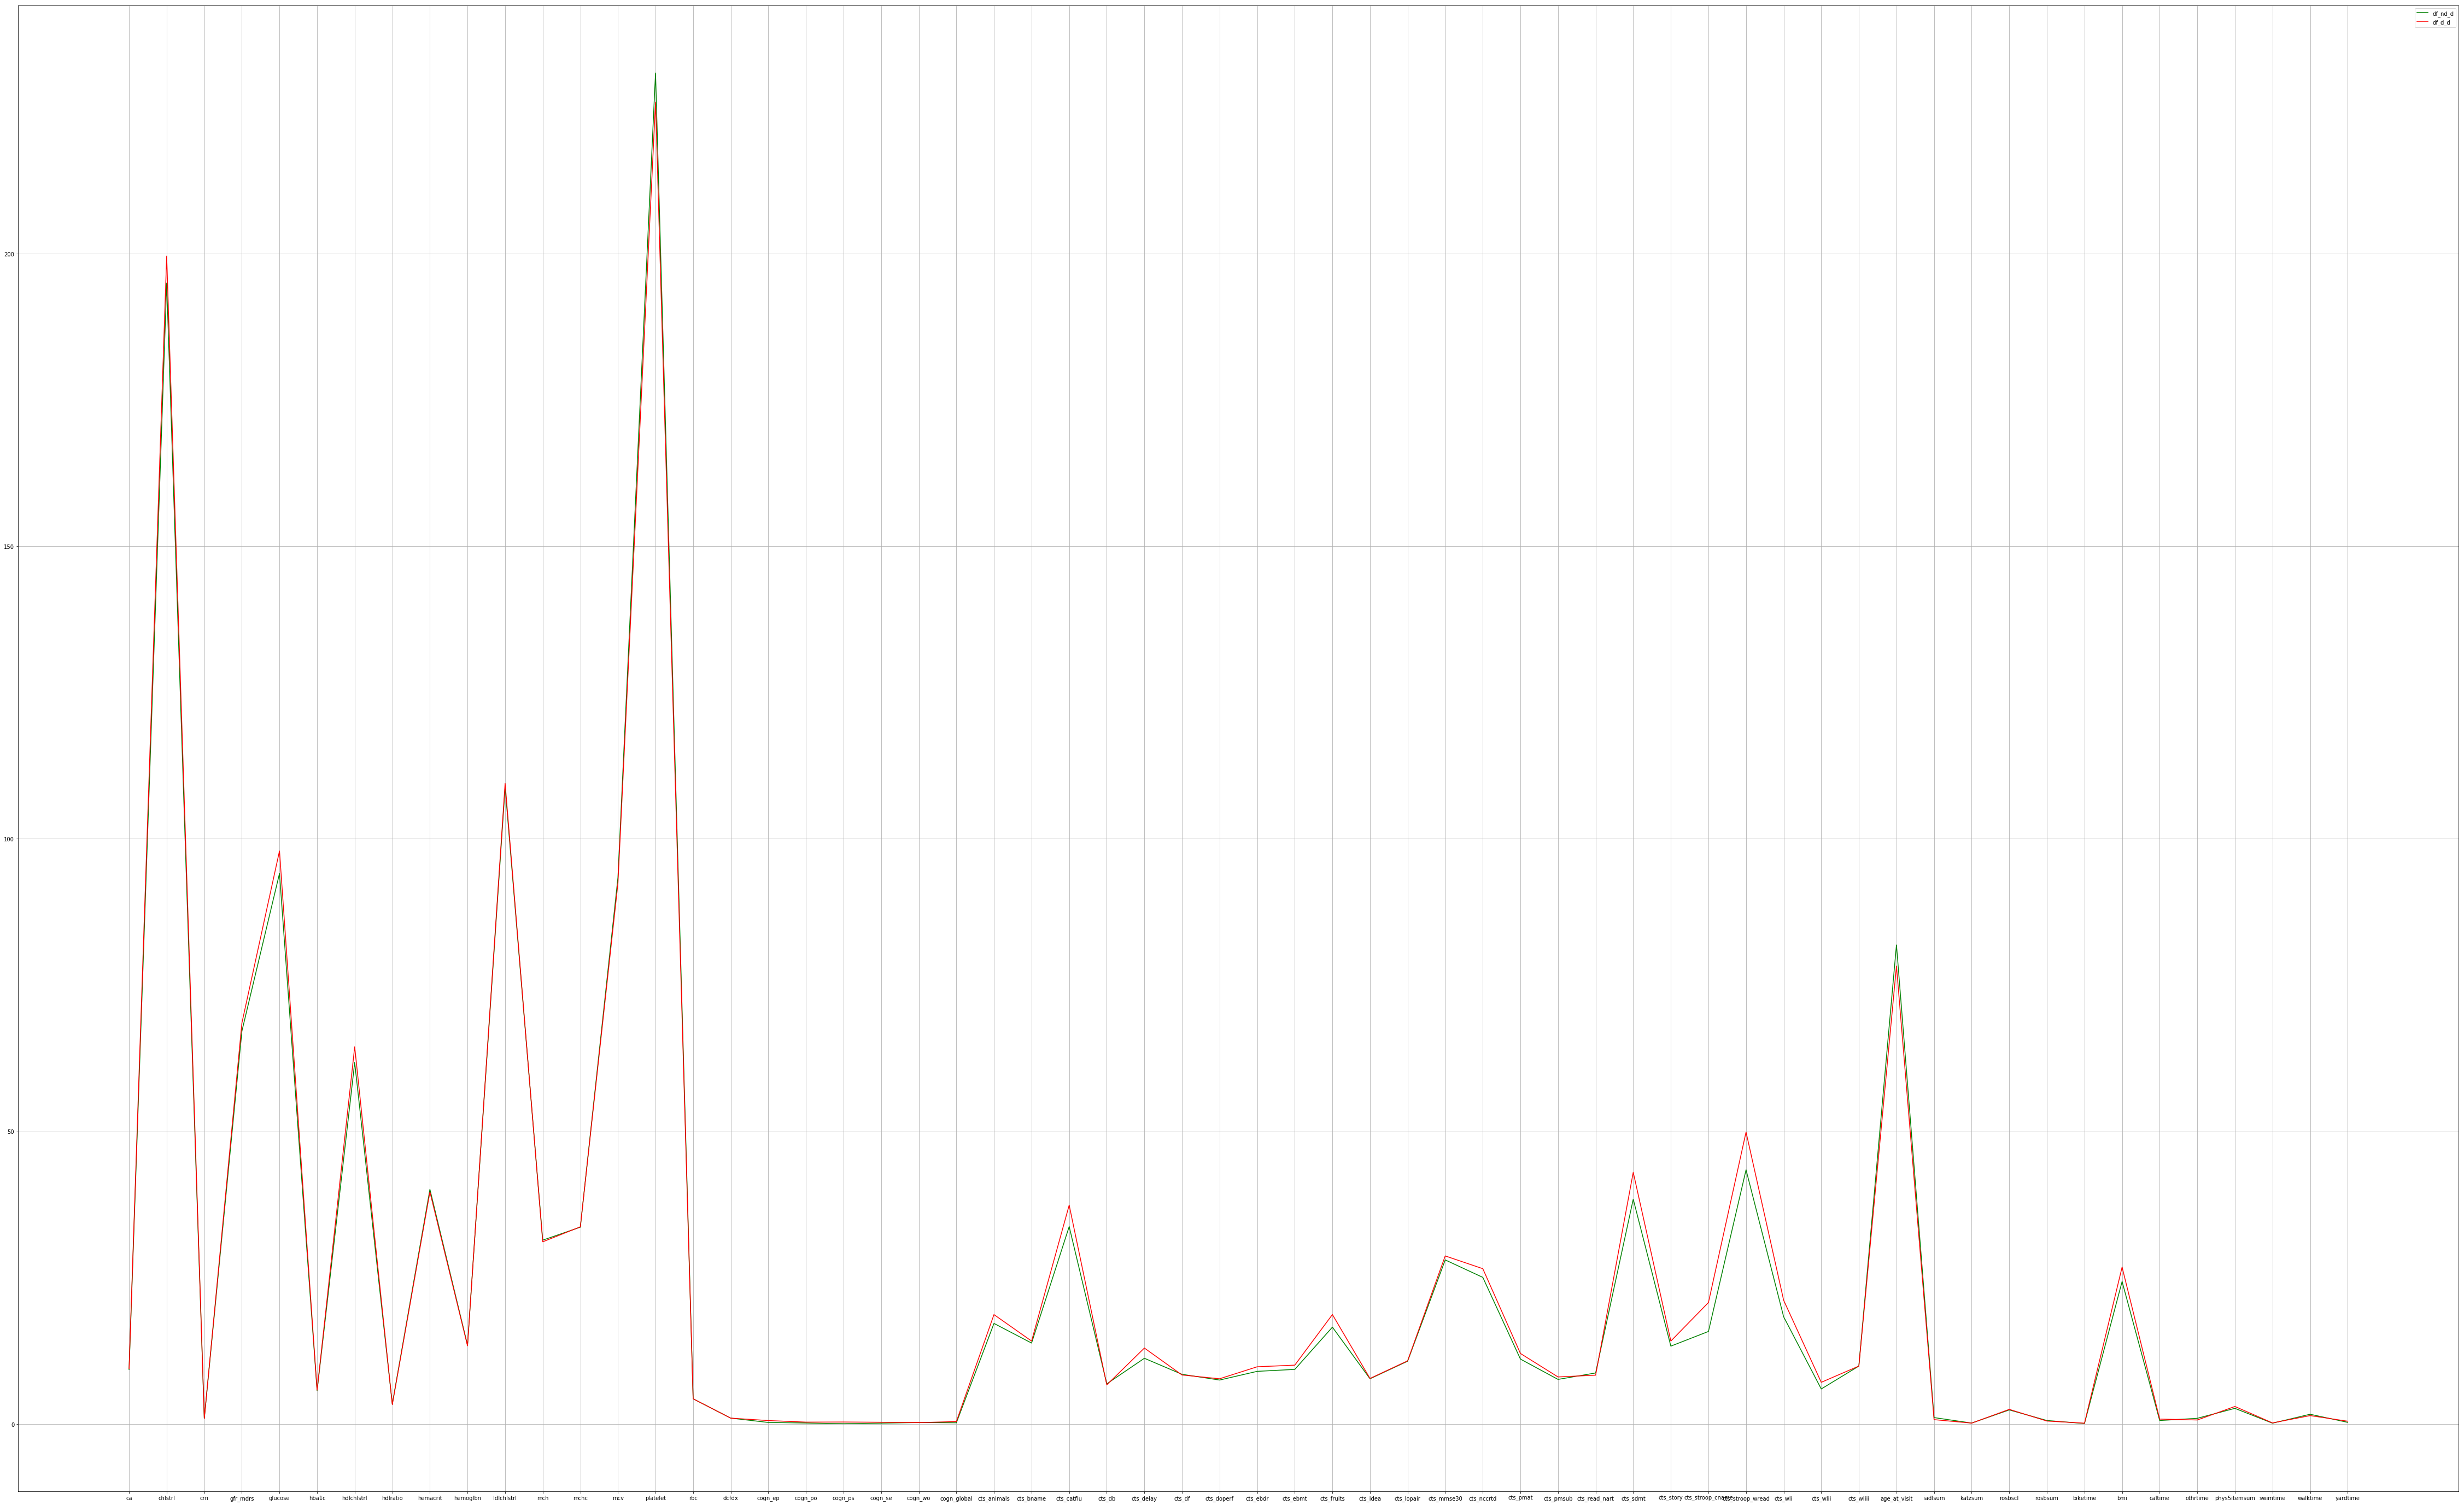

In [143]:
# plot to see any difference?
df_d_d = df_of_patient_in_stage1_but_never_diagnosed.describe()
df_nd_d = df_of_patient_in_stage1_but_diagnosed_in_future.describe()
# df.iloc[1] = mean
plt.figure(figsize=(80,50))
plt.plot(df_nd_d.iloc[1][:60], \
         label='df_nd_d',color="green")
plt.plot(df_d_d.iloc[1][:60], \
         label='df_d_d',color="red")
plt.legend(loc='best')
plt.grid()
plt.show()

In [144]:
# a cts score t test
cts_names_str = \
"phys5itemsum bmi rosbscl katzsum iadlsum age_at_visit rbc dcfdx ca chlstrl crn platelet glucose hba1c hdlchlstrl hdlratio hemacrit hemoglbn ldlchlstrl mch mchc mcv cts_wli cts_wlii cts_wliii cts_ebmt cts_ebdr cts_story cts_delay cts_bname cts_catflu cts_read_nart cts_df cts_db cts_doperf cts_lopair cts_pmat cts_sdmt cts_nccrtd cts_stroop_cname cts_stroop_wread"
# the numeric data witin in these catagolory is test score
cts_names_list = cts_names_str.split(" ")
t_test_result_list = []
for col_name in cts_names_list:
    d_d = df_of_patient_in_stage1_but_diagnosed_in_future[col_name][:]
    nd_d = df_of_patient_in_stage1_but_never_diagnosed[col_name][:]
    d_d = d_d.dropna()
    nd_d = nd_d.dropna()
    t_test_result_list.append(ttest_ind(d_d, nd_d))
    
for result in range(0, len(t_test_result_list)):
    print(str(t_test_result_list[result]) + "FROM ------> " + str(cts_names_list[result]))

Ttest_indResult(statistic=-1.1761005487452154, pvalue=0.2396871852240917)FROM ------> phys5itemsum
Ttest_indResult(statistic=-6.411910185585255, pvalue=1.7884049143928766e-10)FROM ------> bmi
Ttest_indResult(statistic=-1.444739336226036, pvalue=0.1486788969439098)FROM ------> rosbscl
Ttest_indResult(statistic=0.27392235595726494, pvalue=0.7841709510870967)FROM ------> katzsum
Ttest_indResult(statistic=3.212288791301045, pvalue=0.0013366435027035045)FROM ------> iadlsum
Ttest_indResult(statistic=6.1975103822101785, pvalue=6.793243596959741e-10)FROM ------> age_at_visit
Ttest_indResult(statistic=-0.0027546648743258764, pvalue=0.9978026326530899)FROM ------> rbc
Ttest_indResult(statistic=nan, pvalue=nan)FROM ------> dcfdx
Ttest_indResult(statistic=-3.458665630765534, pvalue=0.0005651335164106372)FROM ------> ca
Ttest_indResult(statistic=-0.873659903705398, pvalue=0.3825069373685809)FROM ------> chlstrl
Ttest_indResult(statistic=1.176626160786678, pvalue=0.23961659974452063)FROM ------> cr

Summary, since both d and nd patient is at stage 1, they should be having almost the same mean, however, there are difference between them:
1. bmi = very
2. iadlsum
3. age_at_visit = ???
4. ca
5. cts_wli
6. cts_wlii
7. cts_ebmt
8. cts_ebdr
9. cts_story
10. cts_delay
11. cts_bname
12. cts_catflu
13. cts_read_nart
14. cts_pmat
15. cts_sdmt
16. cts_nccrtd
17. cts_stroop_cname
18. cts_stroop_wread

#### Output the data for me to have a closer look in excel

In [145]:
output_table_xlsx(df_of_patient_in_stage1_but_diagnosed_in_future, "df_of_patient_in_stage1_but_diagnosed_in_future")
output_table_xlsx(df_of_patient_in_stage1_but_never_diagnosed, "df_of_patient_in_stage1_but_never_diagnosed")

file created
file created


In [146]:
def output_table_xlsx(df, output_filename): # dataframe, string
    """
    helper function to output df back to xlsx
    to get a better view of all the columns
    """
    writer_excel = pd.ExcelWriter(output_filename + ".xlsx")
    df.to_excel(writer_excel, 'Sheet1')
    print ("file created")
    
#Override
def extract_stages_from_listofDF(list_of_df, stage=1, stage2=2):
    # first create a df to hold
    df_column_name_list = list(list_of_df[0]) # any list item is fine
    new_df_for_return = pd.DataFrame(columns=df_column_name_list)
    # loop through the list of df and add the one with dcfdx = 1 to the new DF
    for df in list_of_df:
        tot_rows_of_this_df = df.shape[0]
        for row_index in range(0, tot_rows_of_this_df):
            if df.iloc[row_index]['dcfdx'] == stage or df.iloc[row_index]['dcfdx'] == stage2:
                new_df_for_return = new_df_for_return.append(df.iloc[row_index], ignore_index= True)
            else:
                pass
    return new_df_for_return # the value returned is a DF

In [154]:
df_for_processing_d_in_f = extract_stages_from_listofDF(list_of_patient_diagnosed)
df_for_processing_nd_in_f = extract_stages_from_listofDF(list_of_patient_not_diagnosed)

In [189]:
list_of_patient_extract_from_df_d_in_f = grouping(df_for_processing_d_in_f)
list_of_patient_extract_from_df_nd_in_f = grouping(df_for_processing_nd_in_f)
# acquire patient list // both of them is stage 1, but one diagnosed, one not diagnosed in future

### Var reminder:
    1. list_of_patient_extract_from_df_d_in_f == each item is a patient that is diagnoed in future, each item contains a df that about that patient from stage 1 -> 2
    2. list_of_patient_extract_from_df_nd_in_f == same as above but for people that never diagnosed

In [191]:
def interval_calucation(list_of_df):
    """this function takes in the list of patient, then it create a new list, that is the same as the
    old list, except now that each list item is a patient, and the each row is now the interval difference
    between each visit, the value there is now THE DIFFERENCE
    
    The return will be a list_of_df that, each item is a patient
    """
    list_if_patient_interval = []

    
    for index in range(0,len(list_of_df)): # loop through every item in the list
        #loop through the list [2:63] is useful
        list_of_df[index] = list_of_df[index].drop(columns=["scaled_to",])
        print(list(list_of_df[index][2:63]))
#test         
interval_calucation(list_of_patient_extract_from_df_d_in_f)

['projid', 'study', 'fu_year', 'ca', 'chlstrl', 'crn', 'gfr_mdrs', 'glucose', 'hba1c', 'hdlchlstrl', 'hdlratio', 'hemacrit', 'hemoglbn', 'ldlchlstrl', 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'dcfdx', 'cogn_ep', 'cogn_po', 'cogn_ps', 'cogn_se', 'cogn_wo', 'cogn_global', 'cts_animals', 'cts_bname', 'cts_catflu', 'cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt', 'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd', 'cts_pmat', 'cts_pmsub', 'cts_read_nart', 'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii', 'age_at_visit', 'iadlsum', 'katzsum', 'rosbscl', 'rosbsum', 'biketime', 'bmi', 'caltime', 'othrtime', 'phys5itemsum', 'swimtime', 'walktime', 'yardtime', 'hypertension_cum', 'cancer_cum', 'dm_cum', 'headinjrloc_cum', 'med_con_sum_cum', 'claudication_cum', 'stroke_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'analgesic_rx', 'mental_health_rx', 'neurologic_rx', 'plateletinhibitor_rx', 'anti_inflammatory_rx',

In [ ]:
df_column_name_list = df_column_name_list = list(list_of_df[index][2:63]) 
        _new_df_temp = pd.DataFrame(columns=df_column_name_list)
        list_if_patient_interval.append(_new_df_temp)
        if list_of_patient[index].shape[0] == 1
            pass
        else:
            # Series.subtract(other, level=None, fill_value=None, axis=0)
            for rows in range(0,list_of_patient[index].shape[0]-1): # loop through the rows of DF
                print(list_of_patient[index].iloc[rows][2:64]) # test-> print a row of DF
                #list_of_patient[index].iloc[rows][2:63].subtract(list_of_patient[index].iloc[rows+1][2:63])
                #print